In [1]:
import sys,os,signal
import os.path

import numpy as np
from numpy import *
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score
from matplotlib.pyplot import *
%matplotlib inline

In [2]:
# os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES']='3'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 6, 'pin_memory': True, 'worker_init_fn': worker_init}
fs = 44100

m = 128
k = 500
d = 4096
window = 16384
stride = 512
regions = 1 + (window - d)/stride

In [5]:
data = musicnet.MusicNet(dataset='test')
with data : 
    for id in data.ids:
        size = len(data.records[id][0])

        print '###############################',id
        y = np.zeros((size,128,11),dtype=np.int8)

        for t in xrange(size):
            print t,'.'

            for label in data.labeltree[id][t]:
                inst,note,_,_,_ = label.data

                if inst != 0:
                    label_index = list(data.labels==inst).index(True)
                    y[t,note,label_index] = 1

        print '\n'
        np.save(os.path.join(data.labels_path,str(id)),y)

2628
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628


4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290


5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948


7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596


9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10

11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
1165

12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
1304

14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
1441

16299
16300
16301
16302
16303
16304
16305
16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327
16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339
16340
16341
16342
16343
16344
16345
16346
16347
16348
16349
16350
16351
16352
16353
16354
16355
16356
16357
16358
16359
16360
16361
16362
16363
16364
16365
16366
16367
16368
16369
16370
16371
16372
16373
16374
16375
16376
16377
16378
16379
16380
16381
16382
16383
16384
16385
16386
16387
16388
16389
16390
16391
16392
16393
16394
16395
16396
16397
16398
16399
16400
16401
16402
16403
16404
16405
16406
16407
16408
16409
16410
16411
16412
16413
16414
16415
16416
16417
16418
16419
16420
16421
16422
16423
16424
16425
16426
16427
16428
16429
16430
16431
16432
16433
16434
16435
16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448
16449
16450
16451
16452
16453
16454
16455
16456
16457
16458
16459
16460
16461
16462
16463
16464
1646

17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
1785

19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
1924

21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
2123

22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
2260

24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144
24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163
24164
24165
24166
24167
24168
24169
24170
24171
24172
24173
24174
24175
24176
24177
24178
24179
24180
24181
24182
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194
24195
24196
24197
24198
24199
24200
24201
24202
24203
24204
24205
24206
24207
24208
24209
24210
24211
24212
24213
24214
24215
24216
24217
24218
24219
24220
24221
24222
24223
24224
24225
24226
24227
24228
24229
24230
24231
24232
24233
24234
24235
24236
24237
24238
24239
24240
24241
24242
24243
2424

25597
25598
25599
25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
25627
25628
25629
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
25727
25728
25729
25730
25731
25732
25733
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
25744
25745
25746
25747
25748
25749
25750
25751
25752
25753
25754
25755
25756
25757
25758
25759
25760
25761
25762
2576

27201
27202
27203
27204
27205
27206
27207
27208
27209
27210
27211
27212
27213
27214
27215
27216
27217
27218
27219
27220
27221
27222
27223
27224
27225
27226
27227
27228
27229
27230
27231
27232
27233
27234
27235
27236
27237
27238
27239
27240
27241
27242
27243
27244
27245
27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
27262
27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295
27296
27297
27298
27299
27300
27301
27302
27303
27304
27305
27306
27307
27308
27309
27310
27311
27312
27313
27314
27315
27316
27317
27318
27319
27320
27321
27322
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332
27333
27334
27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
2736

28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828
28829
28830
28831
28832
28833
28834
28835
28836
28837
28838
28839
28840
28841
28842
28843
28844
28845
28846
28847
28848
28849
28850
28851
28852
28853
2885

30259
30260
30261
30262
30263
30264
30265
30266
30267
30268
30269
30270
30271
30272
30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287
30288
30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300
30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
30380
30381
30382
30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421
30422
30423
30424
3042

31842
31843
31844
31845
31846
31847
31848
31849
31850
31851
31852
31853
31854
31855
31856
31857
31858
31859
31860
31861
31862
31863
31864
31865
31866
31867
31868
31869
31870
31871
31872
31873
31874
31875
31876
31877
31878
31879
31880
31881
31882
31883
31884
31885
31886
31887
31888
31889
31890
31891
31892
31893
31894
31895
31896
31897
31898
31899
31900
31901
31902
31903
31904
31905
31906
31907
31908
31909
31910
31911
31912
31913
31914
31915
31916
31917
31918
31919
31920
31921
31922
31923
31924
31925
31926
31927
31928
31929
31930
31931
31932
31933
31934
31935
31936
31937
31938
31939
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
3200

33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
3363

35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144
35145
35146
35147
35148
35149
35150
35151
35152
35153
35154
35155
35156
35157
35158
35159
35160
35161
35162
35163
35164
35165
35166
35167
35168
35169
35170
35171
35172
35173
35174
35175
35176
35177
35178
35179
35180
35181
35182
35183
35184
35185
35186
35187
35188
35189
35190
35191
35192
35193
35194
35195
35196
35197
35198
35199
35200
35201
35202
35203
35204
35205
35206
35207
35208
35209
35210
35211
35212
35213
35214
35215
35216
35217
35218
35219
35220
35221
35222
35223
35224
35225
35226
35227
35228
35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
35240
35241
35242
35243
35244
35245
35246
35247
35248
35249
35250
35251
35252
35253
35254
35255
35256
35257
35258
35259
35260
35261
35262
35263
35264
35265
35266
35267
35268
35269
35270
35271
35272
35273
35274
35275
35276
35277
35278
35279
35280
35281
35282
35283
35284
35285
35286
3528

36777
36778
36779
36780
36781
36782
36783
36784
36785
36786
36787
36788
36789
36790
36791
36792
36793
36794
36795
36796
36797
36798
36799
36800
36801
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
36841
36842
36843
36844
36845
36846
36847
36848
36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
36872
36873
36874
36875
36876
36877
36878
36879
36880
36881
36882
36883
36884
36885
36886
36887
36888
36889
36890
36891
36892
36893
36894
36895
36896
36897
36898
36899
36900
36901
36902
36903
36904
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
36916
36917
36918
36919
36920
36921
36922
36923
36924
36925
36926
36927
36928
36929
36930
36931
36932
36933
36934
36935
36936
36937
36938
36939
36940
36941
36942
3694

38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38332
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397
38398
38399
38400
38401
38402
3840

39666
39667
39668
39669
39670
39671
39672
39673
39674
39675
39676
39677
39678
39679
39680
39681
39682
39683
39684
39685
39686
39687
39688
39689
39690
39691
39692
39693
39694
39695
39696
39697
39698
39699
39700
39701
39702
39703
39704
39705
39706
39707
39708
39709
39710
39711
39712
39713
39714
39715
39716
39717
39718
39719
39720
39721
39722
39723
39724
39725
39726
39727
39728
39729
39730
39731
39732
39733
39734
39735
39736
39737
39738
39739
39740
39741
39742
39743
39744
39745
39746
39747
39748
39749
39750
39751
39752
39753
39754
39755
39756
39757
39758
39759
39760
39761
39762
39763
39764
39765
39766
39767
39768
39769
39770
39771
39772
39773
39774
39775
39776
39777
39778
39779
39780
39781
39782
39783
39784
39785
39786
39787
39788
39789
39790
39791
39792
39793
39794
39795
39796
39797
39798
39799
39800
39801
39802
39803
39804
39805
39806
39807
39808
39809
39810
39811
39812
39813
39814
39815
39816
39817
39818
39819
39820
39821
39822
39823
39824
39825
39826
39827
39828
39829
39830
39831
3983

41698
41699
41700
41701
41702
41703
41704
41705
41706
41707
41708
41709
41710
41711
41712
41713
41714
41715
41716
41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733
41734
41735
41736
41737
41738
41739
41740
41741
41742
41743
41744
41745
41746
41747
41748
41749
41750
41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769
41770
41771
41772
41773
41774
41775
41776
41777
41778
41779
41780
41781
41782
41783
41784
41785
41786
41787
41788
41789
41790
41791
41792
41793
41794
41795
41796
41797
41798
41799
41800
41801
41802
41803
41804
41805
41806
41807
41808
41809
41810
41811
41812
41813
41814
41815
41816
41817
41818
41819
41820
41821
41822
41823
41824
41825
41826
41827
41828
41829
41830
41831
41832
41833
41834
41835
41836
41837
41838
41839
41840
41841
41842
41843
41844
41845
41846
41847
41848
41849
41850
41851
41852
41853
41854
41855
41856
41857
41858
41859
41860
41861
41862
41863
4186

43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
43147
43148
43149
43150
43151
43152
43153
43154
43155
43156
43157
43158
43159
43160
43161
43162
43163
43164
43165
43166
43167
43168
43169
43170
43171
43172
43173
43174
43175
43176
43177
43178
43179
43180
43181
43182
43183
43184
43185
43186
43187
43188
43189
43190
43191
43192
43193
43194
43195
43196
43197
43198
43199
43200
43201
43202
43203
43204
43205
43206
43207
43208
43209
43210
43211
43212
43213
43214
43215
43216
43217
43218
43219
43220
43221
43222
43223
43224
43225
43226
43227
43228
43229
43230
43231
43232
43233
43234
43235
43236
43237
43238
43239
43240
43241
43242
43243
43244
43245
43246
43247
43248
43249
43250
43251
43252
43253
43254
43255
43256
43257
43258
43259
43260
43261
43262
43263
43264
43265
43266
43267
43268
43269
43270
43271
43272
43273
43274
43275
4327

44924
44925
44926
44927
44928
44929
44930
44931
44932
44933
44934
44935
44936
44937
44938
44939
44940
44941
44942
44943
44944
44945
44946
44947
44948
44949
44950
44951
44952
44953
44954
44955
44956
44957
44958
44959
44960
44961
44962
44963
44964
44965
44966
44967
44968
44969
44970
44971
44972
44973
44974
44975
44976
44977
44978
44979
44980
44981
44982
44983
44984
44985
44986
44987
44988
44989
44990
44991
44992
44993
44994
44995
44996
44997
44998
44999
45000
45001
45002
45003
45004
45005
45006
45007
45008
45009
45010
45011
45012
45013
45014
45015
45016
45017
45018
45019
45020
45021
45022
45023
45024
45025
45026
45027
45028
45029
45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
4509

46634
46635
46636
46637
46638
46639
46640
46641
46642
46643
46644
46645
46646
46647
46648
46649
46650
46651
46652
46653
46654
46655
46656
46657
46658
46659
46660
46661
46662
46663
46664
46665
46666
46667
46668
46669
46670
46671
46672
46673
46674
46675
46676
46677
46678
46679
46680
46681
46682
46683
46684
46685
46686
46687
46688
46689
46690
46691
46692
46693
46694
46695
46696
46697
46698
46699
46700
46701
46702
46703
46704
46705
46706
46707
46708
46709
46710
46711
46712
46713
46714
46715
46716
46717
46718
46719
46720
46721
46722
46723
46724
46725
46726
46727
46728
46729
46730
46731
46732
46733
46734
46735
46736
46737
46738
46739
46740
46741
46742
46743
46744
46745
46746
46747
46748
46749
46750
46751
46752
46753
46754
46755
46756
46757
46758
46759
46760
46761
46762
46763
46764
46765
46766
46767
46768
46769
46770
46771
46772
46773
46774
46775
46776
46777
46778
46779
46780
46781
46782
46783
46784
46785
46786
46787
46788
46789
46790
46791
46792
46793
46794
46795
46796
46797
46798
46799
4680

48222
48223
48224
48225
48226
48227
48228
48229
48230
48231
48232
48233
48234
48235
48236
48237
48238
48239
48240
48241
48242
48243
48244
48245
48246
48247
48248
48249
48250
48251
48252
48253
48254
48255
48256
48257
48258
48259
48260
48261
48262
48263
48264
48265
48266
48267
48268
48269
48270
48271
48272
48273
48274
48275
48276
48277
48278
48279
48280
48281
48282
48283
48284
48285
48286
48287
48288
48289
48290
48291
48292
48293
48294
48295
48296
48297
48298
48299
48300
48301
48302
48303
48304
48305
48306
48307
48308
48309
48310
48311
48312
48313
48314
48315
48316
48317
48318
48319
48320
48321
48322
48323
48324
48325
48326
48327
48328
48329
48330
48331
48332
48333
48334
48335
48336
48337
48338
48339
48340
48341
48342
48343
48344
48345
48346
48347
48348
48349
48350
48351
48352
48353
48354
48355
48356
48357
48358
48359
48360
48361
48362
48363
48364
48365
48366
48367
48368
48369
48370
48371
48372
48373
48374
48375
48376
48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
4838

49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
49827
49828
49829
49830
49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
4997

51710
51711
51712
51713
51714
51715
51716
51717
51718
51719
51720
51721
51722
51723
51724
51725
51726
51727
51728
51729
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51762
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
51775
51776
51777
51778
51779
51780
51781
51782
51783
51784
51785
51786
51787
51788
51789
51790
51791
51792
51793
51794
51795
51796
51797
51798
51799
51800
51801
51802
51803
51804
51805
51806
51807
51808
51809
51810
51811
51812
51813
51814
51815
51816
51817
51818
51819
51820
51821
51822
51823
51824
51825
51826
51827
51828
51829
51830
51831
51832
51833
51834
51835
51836
51837
51838
51839
51840
51841
51842
51843
51844
51845
51846
51847
51848
51849
51850
51851
51852
51853
51854
51855
51856
51857
51858
51859
51860
51861
51862
51863
51864
51865
51866
51867
51868
51869
51870
51871
51872
51873
51874
51875
5187

53667
53668
53669
53670
53671
53672
53673
53674
53675
53676
53677
53678
53679
53680
53681
53682
53683
53684
53685
53686
53687
53688
53689
53690
53691
53692
53693
53694
53695
53696
53697
53698
53699
53700
53701
53702
53703
53704
53705
53706
53707
53708
53709
53710
53711
53712
53713
53714
53715
53716
53717
53718
53719
53720
53721
53722
53723
53724
53725
53726
53727
53728
53729
53730
53731
53732
53733
53734
53735
53736
53737
53738
53739
53740
53741
53742
53743
53744
53745
53746
53747
53748
53749
53750
53751
53752
53753
53754
53755
53756
53757
53758
53759
53760
53761
53762
53763
53764
53765
53766
53767
53768
53769
53770
53771
53772
53773
53774
53775
53776
53777
53778
53779
53780
53781
53782
53783
53784
53785
53786
53787
53788
53789
53790
53791
53792
53793
53794
53795
53796
53797
53798
53799
53800
53801
53802
53803
53804
53805
53806
53807
53808
53809
53810
53811
53812
53813
53814
53815
53816
53817
53818
53819
53820
53821
53822
53823
53824
53825
53826
53827
53828
53829
53830
53831
53832
5383

55485
55486
55487
55488
55489
55490
55491
55492
55493
55494
55495
55496
55497
55498
55499
55500
55501
55502
55503
55504
55505
55506
55507
55508
55509
55510
55511
55512
55513
55514
55515
55516
55517
55518
55519
55520
55521
55522
55523
55524
55525
55526
55527
55528
55529
55530
55531
55532
55533
55534
55535
55536
55537
55538
55539
55540
55541
55542
55543
55544
55545
55546
55547
55548
55549
55550
55551
55552
55553
55554
55555
55556
55557
55558
55559
55560
55561
55562
55563
55564
55565
55566
55567
55568
55569
55570
55571
55572
55573
55574
55575
55576
55577
55578
55579
55580
55581
55582
55583
55584
55585
55586
55587
55588
55589
55590
55591
55592
55593
55594
55595
55596
55597
55598
55599
55600
55601
55602
55603
55604
55605
55606
55607
55608
55609
55610
55611
55612
55613
55614
55615
55616
55617
55618
55619
55620
55621
55622
55623
55624
55625
55626
55627
55628
55629
55630
55631
55632
55633
55634
55635
55636
55637
55638
55639
55640
55641
55642
55643
55644
55645
55646
55647
55648
55649
55650
5565

57624
57625
57626
57627
57628
57629
57630
57631
57632
57633
57634
57635
57636
57637
57638
57639
57640
57641
57642
57643
57644
57645
57646
57647
57648
57649
57650
57651
57652
57653
57654
57655
57656
57657
57658
57659
57660
57661
57662
57663
57664
57665
57666
57667
57668
57669
57670
57671
57672
57673
57674
57675
57676
57677
57678
57679
57680
57681
57682
57683
57684
57685
57686
57687
57688
57689
57690
57691
57692
57693
57694
57695
57696
57697
57698
57699
57700
57701
57702
57703
57704
57705
57706
57707
57708
57709
57710
57711
57712
57713
57714
57715
57716
57717
57718
57719
57720
57721
57722
57723
57724
57725
57726
57727
57728
57729
57730
57731
57732
57733
57734
57735
57736
57737
57738
57739
57740
57741
57742
57743
57744
57745
57746
57747
57748
57749
57750
57751
57752
57753
57754
57755
57756
57757
57758
57759
57760
57761
57762
57763
57764
57765
57766
57767
57768
57769
57770
57771
57772
57773
57774
57775
57776
57777
57778
57779
57780
57781
57782
57783
57784
57785
57786
57787
57788
57789
5779

59436
59437
59438
59439
59440
59441
59442
59443
59444
59445
59446
59447
59448
59449
59450
59451
59452
59453
59454
59455
59456
59457
59458
59459
59460
59461
59462
59463
59464
59465
59466
59467
59468
59469
59470
59471
59472
59473
59474
59475
59476
59477
59478
59479
59480
59481
59482
59483
59484
59485
59486
59487
59488
59489
59490
59491
59492
59493
59494
59495
59496
59497
59498
59499
59500
59501
59502
59503
59504
59505
59506
59507
59508
59509
59510
59511
59512
59513
59514
59515
59516
59517
59518
59519
59520
59521
59522
59523
59524
59525
59526
59527
59528
59529
59530
59531
59532
59533
59534
59535
59536
59537
59538
59539
59540
59541
59542
59543
59544
59545
59546
59547
59548
59549
59550
59551
59552
59553
59554
59555
59556
59557
59558
59559
59560
59561
59562
59563
59564
59565
59566
59567
59568
59569
59570
59571
59572
59573
59574
59575
59576
59577
59578
59579
59580
59581
59582
59583
59584
59585
59586
59587
59588
59589
59590
59591
59592
59593
59594
59595
59596
59597
59598
59599
59600
59601
5960

KeyboardInterrupt: 

In [6]:
size

21994112

In [ ]:
print 'x'

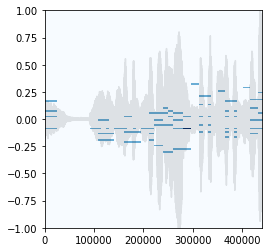

In [32]:
with data:

    X,Y = data[1]
    plt.plot(X/amax(X),'k',alpha=0.1) 
    
    pitch = sum(Y,axis=-1)    
    imshow(pitch.T,
           aspect=pitch.shape[0]/2,
           origin='bottom',
           extent=(0,pitch.shape[0],-1,1),
           cmap='Blues')

In [33]:
Audio(X,rate=fs)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [ ]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [ ]:
wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand(regions*k,m).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) \
       + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

# Train the model

In [ ]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [ ]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print 'square loss\tavg prec\ttime\t\tutime'
        for epoch in xrange(50):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                optimizer.zero_grad()
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(forward(x,*weights),y,*weights)
                loss.backward()
                optimizer.step()

                for w,wavg in zip(weights, averages):
                    wavg.copy_(avg*wavg + (1.-avg)*w)

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            for i, (x, y) in enumerate(test_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                yhatvar = forward(x,*averages)
                loss += L(yhatvar,y,*averages).data[0]
                yground[i*batch_size:(i+1)*batch_size,:] = y.data
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print '{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1)

except KeyboardInterrupt:
    print 'Graceful Exit'
else:
    print 'Finished'

In [ ]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])